<a href="https://colab.research.google.com/github/Saranja-Navaneethakumar/Hybrid-Movie-recommendation/blob/main/Code_for_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2611303 sha256=8fae75c1b6b4d0a8b1abd7a9a0b97bb24210d00fef14870c72e652701d8259b4
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise



--- Training Blended CF Model for 1M ---
Computing the msd similarity matrix...
Done computing similarity matrix.
--- Training Hybrid MLP Model (Regressor) for 1M ---
Epoch 1/70
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 3.1058 - root_mean_squared_error: 1.6716 - val_loss: 0.8217 - val_root_mean_squared_error: 0.9065
Epoch 2/70
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - loss: 0.8086 - root_mean_squared_error: 0.8992 - val_loss: 0.7750 - val_root_mean_squared_error: 0.8803
Epoch 3/70
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - loss: 0.7419 - root_mean_squared_error: 0.8613 - val_loss: 0.7549 - val_root_mean_squared_error: 0.8688
Epoch 4/70
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 84s 18ms/step - loss: 0.7019 - root_mean_squared_error: 0.8378 - val_loss: 0.7424 - val_root_mean_squared_error: 0.8616
Epoch 5/70
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.6734 - root_mean_squared_error: 0.8206 - val_loss: 0.7393 - val_root_mean_squared_error: 0.8598
Epoch 6/70
3126/3126 ━

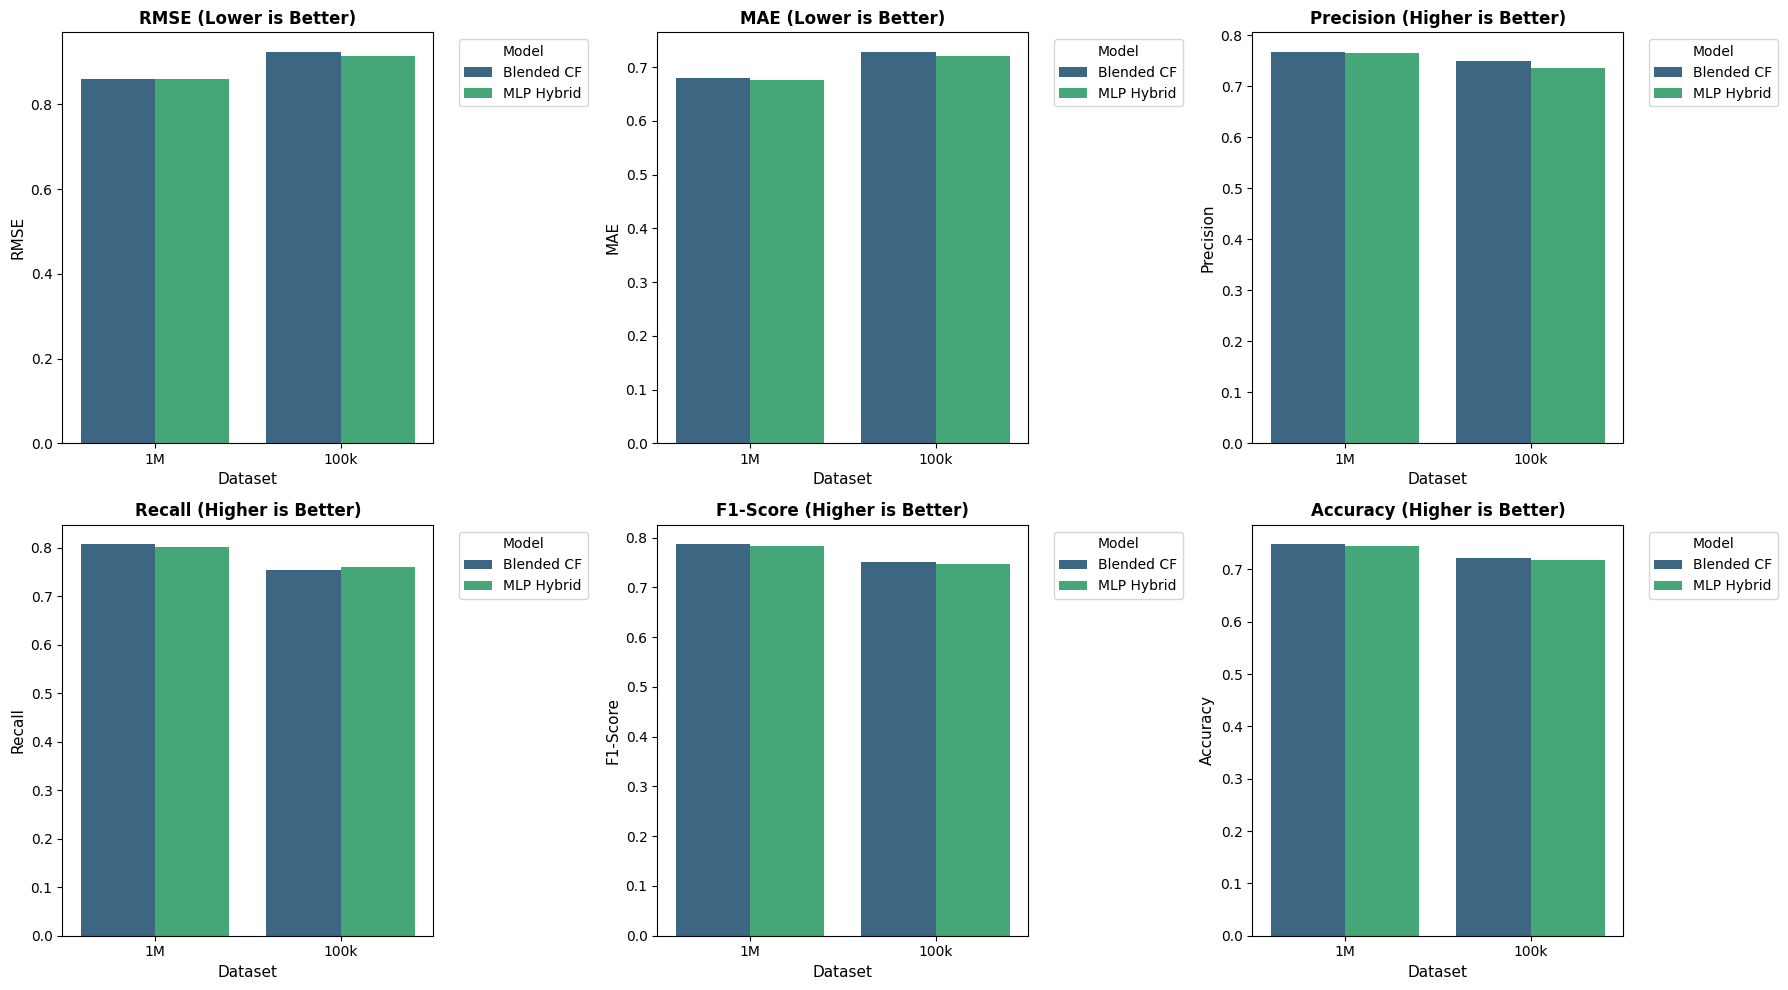


--- Detailed Visualizations for Last MLP Model ---


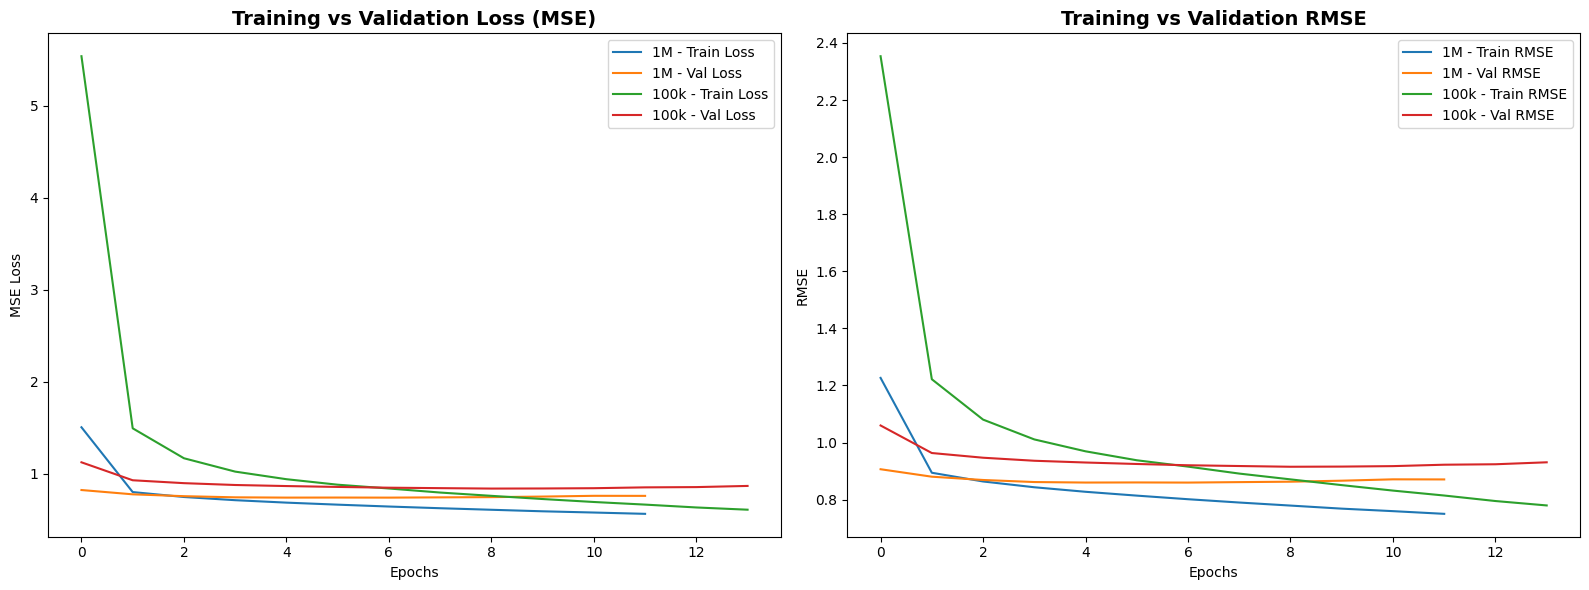

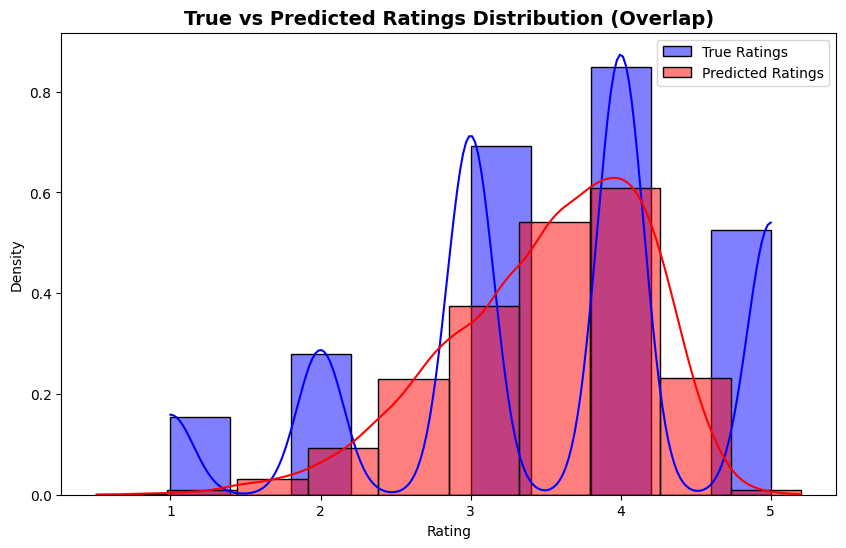

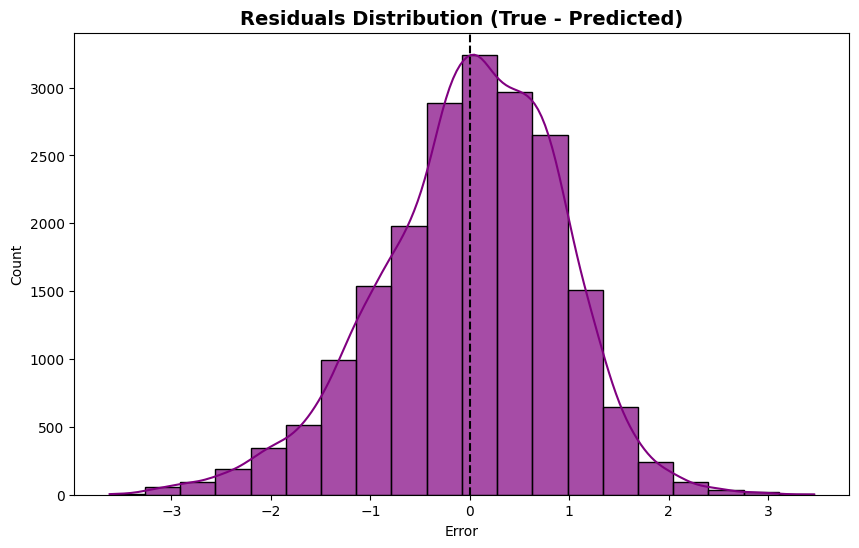

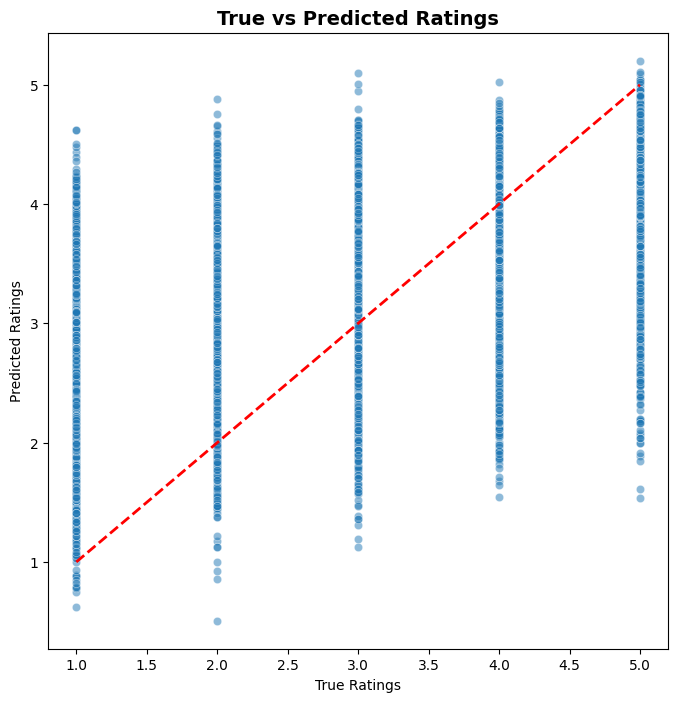

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from surprise import Reader, Dataset, SVD, KNNBasic, Prediction
from surprise.model_selection import train_test_split as surprise_train_test_split, RandomizedSearchCV
from surprise.accuracy import rmse, mae
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Data Loading and Preprocessing Functions ---

def load_data(dataset_name):
    """Loads and preprocesses data for a specified MovieLens dataset."""
    try:
        if dataset_name == '1M':
            DATA_PATH = '/content/drive/MyDrive/UCB/Research/Dataset/ml-1m'
            movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movies.dat'), sep='::', engine='python', names=['movieId', 'title', 'genres'], encoding='latin1')
            ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.dat'), sep='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])
            users_df = pd.read_csv(os.path.join(DATA_PATH, 'users.dat'), sep='::', engine='python', names=['userId', 'gender', 'age', 'occupation', 'zip-code'])
        elif dataset_name == '100k':
            DATA_PATH = '/content/drive/MyDrive/UCB/Research/Dataset/ml-100k'
            movies_df = pd.read_csv(os.path.join(DATA_PATH, 'u.item'), sep='|', header=None, engine='python', encoding='latin1')

            movie_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url']
            genre_cols = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
                          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
            movies_df.columns = movie_cols + genre_cols

            def get_genres(row):
                genres_list = [genre for genre in genre_cols if row[genre] == 1]
                return '|'.join(genres_list)

            movies_df['genres'] = movies_df.apply(get_genres, axis=1)
            movies_df = movies_df[['movieId', 'title', 'genres']]

            ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'u.data'), sep='\t', header=None, engine='python', encoding='latin1')
            ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

            users_df = pd.read_csv(os.path.join(DATA_PATH, 'u.user'), sep='|', header=None, engine='python', encoding='latin1')
            users_df.columns = ['userId', 'age', 'gender', 'occupation', 'zip-code']
        else:
            raise ValueError("Invalid dataset name. Choose '1M' or '100k'.")

        merged_df = pd.merge(ratings_df, users_df, on='userId')
        merged_df = pd.merge(merged_df, movies_df, on='movieId')

       # --- Basic Cleaning ---
        merged_df = merged_df.drop_duplicates().dropna(subset=['rating', 'title', 'genres'])
        movies_df = movies_df.drop_duplicates().dropna(subset=['title', 'genres'])

        merged_df['title'] = merged_df['title'].str.strip()
        merged_df['genres'] = merged_df['genres'].str.strip()
        movies_df['title'] = movies_df['title'].str.strip()
        movies_df['genres'] = movies_df['genres'].str.strip()

        return merged_df, ratings_df, movies_df, users_df

    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure dataset files are in the correct path for '{dataset_name}'.")
        return None, None, None, None


# --- Recommendation Functions ---

def get_user_recommendations(user_id, model, movies_df, ratings_df, n_recommendations=10):
    """Generates top N movie recommendations for a user using a trained model."""
    all_movie_ids = ratings_df['movieId'].unique()
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]

    predictions = [model.predict(uid=user_id, iid=mid) for mid in unrated_movies]
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n_recommendations]

    recommendations = []
    for pred in top_n_predictions:
        movie_title = movies_df[movies_df['movieId'] == pred.iid]['title'].iloc[0]
        recommendations.append((movie_title, pred.est))
    return recommendations

def get_similar_movies(movie_id, knn_model, movies_df, n_recommendations=10):
    """Generates top N similar movies for a given movie using a KNN model."""
    try:
        movie_inner_id = knn_model.trainset.to_inner_iid(movie_id)
        movie_neighbors_inner_ids = knn_model.get_neighbors(movie_inner_id, k=n_recommendations)
        similar_movies = []
        for inner_id in movie_neighbors_inner_ids:
            original_movie_id = knn_model.trainset.to_raw_iid(inner_id)
            movie_title = movies_df[movies_df['movieId'] == original_movie_id]['title'].iloc[0]
            similar_movies.append(movie_title)
        return similar_movies
    except ValueError:
        return ["Movie not found in the dataset."]

# --- Model Training and Evaluation Functions ---

def evaluate_top_n_metrics(predictions, rating_threshold=4.0, prediction_threshold=3.5):
    """
    Calculates Precision, Recall, and F1-Score for a set of predictions.
    A positive prediction is defined as an estimated rating > prediction_threshold.
    A true positive is an estimated rating > prediction_threshold for an item with an actual rating >= rating_threshold.
    """
    true_ratings = np.array([pred.r_ui for pred in predictions])
    predicted_ratings = np.array([pred.est for pred in predictions])

    # Binarize based on the thresholds
    y_true = (true_ratings >= rating_threshold).astype(int)
    y_pred = (predicted_ratings > prediction_threshold).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1

def calculate_accuracy(predictions, rating_threshold=4.0, prediction_threshold=3.5):
    """
    Calculates simple classification accuracy for a set of predictions.
    This is based on binarizing the ratings and predictions using thresholds.
    """
    true_ratings = np.array([pred.r_ui for pred in predictions])
    predicted_ratings = np.array([pred.est for pred in predictions])

    y_true_bin = (true_ratings >= rating_threshold).astype(int)
    y_pred_bin = (predicted_ratings > prediction_threshold).astype(int)

    accuracy = accuracy_score(y_true_bin, y_pred_bin)

    return accuracy


def train_blended_cf_model(ratings_df):
    """Trains and evaluates the Blended Collaborative Filtering model with expanded SVD tuning."""
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = surprise_train_test_split(data, test_size=0.25, random_state=42)

    param_grid = {
        'n_factors': [100, 150],
        'n_epochs': [40, 50],
        'lr_all': [0.005, 0.01],
        'reg_all': [0.02, 0.04, 0.06]
    }
    rs = RandomizedSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_iter=5, n_jobs=-1, random_state=42)
    rs.fit(data)
    best_svd_algo = rs.best_estimator['rmse']
    best_svd_algo.fit(trainset)

    algo_knn = KNNBasic(sim_options={'user_based': False})
    algo_knn.fit(trainset)

    svd_predictions = best_svd_algo.test(testset)
    knn_predictions = algo_knn.test(testset)

    blended_predictions = []
    for svd_pred, knn_pred in zip(svd_predictions, knn_predictions):
        blended_est = (svd_pred.est * 0.7) + (knn_pred.est * 0.3)
        blended_predictions.append(Prediction(uid=svd_pred.uid, iid=svd_pred.iid, r_ui=svd_pred.r_ui, est=blended_est, details={}))

    blended_rmse = rmse(blended_predictions, verbose=False)
    blended_mae = mae(blended_predictions, verbose=False)

    blended_precision, blended_recall, blended_f1 = evaluate_top_n_metrics(blended_predictions)
    blended_accuracy = calculate_accuracy(blended_predictions)

    return blended_rmse, blended_mae, blended_precision, blended_recall, blended_f1, blended_accuracy, best_svd_algo, algo_knn

def train_mlp_model(df):
    """
    Trains and evaluates the Deep Learning Hybrid (MLP) model as a regressor.
    This version includes user features and genres.
    Returns metrics, the trained model, and encoders for later use.
    """
    user_ids = df['userId'].unique().tolist()
    movie_ids = df['movieId'].unique().tolist()
    user2user_encoded = {x: i for i, x in enumerate(user_ids)}
    movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
    df['user_encoded'] = df['userId'].map(user2user_encoded)
    df['movie_encoded'] = df['movieId'].map(movie2movie_encoded)

    gender_map = {'M': 0, 'F': 1}
    df['gender_encoded'] = df['gender'].map(gender_map)
    occupation_ids = df['occupation'].unique().tolist()
    occupation2occupation_encoded = {x: i for i, x in enumerate(occupation_ids)}
    df['occupation_encoded'] = df['occupation'].map(occupation2occupation_encoded)

    all_genres = sorted(list(set(g for genres in df['genres'].dropna() for g in genres.split('|'))))
    for genre in all_genres:
        df[f'genre_{genre}'] = df['genres'].apply(lambda x: 1 if pd.notna(x) and genre in x else 0)

    num_users = len(user2user_encoded)
    num_movies = len(movie2movie_encoded)
    num_genders = len(gender_map)
    num_occupations = len(occupation_ids)
    num_genres = len(all_genres)

    scaler = StandardScaler()
    df['age_scaled'] = scaler.fit_transform(df[['age']])

    X_user_encoded = df['user_encoded'].values
    X_movie_encoded = df['movie_encoded'].values
    X_gender_encoded = df['gender_encoded'].values
    X_occupation_encoded = df['occupation_encoded'].values
    X_age_scaled = df['age_scaled'].values
    X_genres = df[[f'genre_{g}' for g in all_genres]].values
    y = df['rating'].values

    train_indices, val_indices = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)

    X_train_user, X_val_user = X_user_encoded[train_indices], X_user_encoded[val_indices]
    X_train_movie, X_val_movie = X_movie_encoded[train_indices], X_movie_encoded[val_indices]
    X_train_gender, X_val_gender = X_gender_encoded[train_indices], X_gender_encoded[val_indices]
    X_train_occ, X_val_occ = X_occupation_encoded[train_indices], X_occupation_encoded[val_indices]
    X_train_age, X_val_age = X_age_scaled[train_indices], X_age_scaled[val_indices]
    X_train_genres, X_val_genres = X_genres[train_indices], X_genres[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    embedding_size = 50
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Flatten()(Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input))
    movie_input = Input(shape=(1,), name='movie_input')
    movie_embedding = Flatten()(Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input))
    gender_input = Input(shape=(1,), name='gender_input')
    gender_embedding = Flatten()(Embedding(input_dim=num_genders, output_dim=10, name='gender_embedding')(gender_input))
    occupation_input = Input(shape=(1,), name='occupation_input')
    occupation_embedding = Flatten()(Embedding(input_dim=num_occupations, output_dim=10, name='occupation_embedding')(occupation_input))
    age_input = Input(shape=(1,), name='age_input')
    genres_input = Input(shape=(num_genres,), name='genres_input')

    concat = Concatenate()([user_embedding, movie_embedding, gender_embedding, occupation_embedding, age_input, genres_input])

    dense1 = Dense(256, activation='relu')(concat)
    dropout1 = Dropout(0.2)(dense1)
    batchnorm1 = BatchNormalization()(dropout1)

    dense2 = Dense(128, activation='relu')(batchnorm1)
    dropout2 = Dropout(0.2)(dense2)
    batchnorm2 = BatchNormalization()(dropout2)

    dense3 = Dense(64, activation='relu')(batchnorm2)
    dropout3 = Dropout(0.2)(dense3)
    batchnorm3 = BatchNormalization()(dropout3)

    output = Dense(1, activation='linear')(batchnorm3)

    model = Model(inputs=[user_input, movie_input, gender_input, occupation_input, age_input, genres_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        [X_train_user, X_train_movie, X_train_gender, X_train_occ, X_train_age, X_train_genres], y_train,
        batch_size=256, epochs=70, verbose=1,
        validation_data=([X_val_user, X_val_movie, X_val_gender, X_val_occ, X_val_age, X_val_genres], y_val),
        callbacks=[early_stopping])

    y_pred = model.predict([X_val_user, X_val_movie, X_val_gender, X_val_occ, X_val_age, X_val_genres], verbose=0).flatten()

    mlp_rmse = np.sqrt(np.mean((y_val - y_pred)**2))
    mlp_mae = np.mean(np.abs(y_val - y_pred))

    # Binarize for classification metrics
    y_true_bin = (y_val >= 4.0).astype(int)
    y_pred_bin = (y_pred > 3.5).astype(int)

    mlp_precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    mlp_recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    mlp_f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
    mlp_accuracy = accuracy_score(y_true_bin, y_pred_bin)

    # return metrics + model + encoders
    return (
        mlp_rmse, mlp_mae, mlp_precision, mlp_recall, mlp_f1, mlp_accuracy,
        model, user2user_encoded, movie2movie_encoded, occupation2occupation_encoded, gender_map, all_genres, scaler, history, y_val, y_pred
    )

def get_user_recommendations_mlp(user_id, model, df, movies_df, n_recommendations=10):
    """
    Generate top-N recommendations for a user using the trained MLP model.
    """
    # --- encoders and metadata from training ---
    user2user_encoded = {x: i for i, x in enumerate(df['userId'].unique())}
    movie2movie_encoded = {x: i for i, x in enumerate(df['movieId'].unique())}
    occupation2occupation_encoded = {x: i for i, x in enumerate(df['occupation'].unique())}
    gender_map = {'M': 0, 'F': 1}

    # Genres used during training
    all_genres = sorted(list(set(g for genres in df['genres'].dropna() for g in genres.split('|'))))

    # Get user features
    user_row = df[df['userId'] == user_id].iloc[0]  # take one row of this user
    user_encoded = user2user_encoded[user_id]
    gender_encoded = gender_map[user_row['gender']]
    occ_encoded = occupation2occupation_encoded[user_row['occupation']]
    age_scaled = user_row['age_scaled']

    # Get all candidate movies not yet rated
    rated_movies = df[df['userId'] == user_id]['movieId'].tolist()
    all_movie_ids = movies_df['movieId'].unique()
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]

    # Build input features for all unrated movies
    X_user = []
    X_movie = []
    X_gender = []
    X_occ = []
    X_age = []
    X_genres = []

    for mid in unrated_movies:
        if mid not in movie2movie_encoded:
            continue  # skip unknown movies
        movie_encoded = movie2movie_encoded[mid]

        # one-hot genres
        movie_genres = movies_df[movies_df['movieId'] == mid]['genres'].iloc[0]
        genres_vector = [1 if g in movie_genres else 0 for g in all_genres]

        # collect features
        X_user.append(user_encoded)
        X_movie.append(movie_encoded)
        X_gender.append(gender_encoded)
        X_occ.append(occ_encoded)
        X_age.append(age_scaled)
        X_genres.append(genres_vector)

    # Convert to numpy arrays
    X_user = np.array(X_user)
    X_movie = np.array(X_movie)
    X_gender = np.array(X_gender)
    X_occ = np.array(X_occ)
    X_age = np.array(X_age)
    X_genres = np.array(X_genres)

    # Predict ratings
    preds = model.predict([X_user, X_movie, X_gender, X_occ, X_age, X_genres], verbose=0).flatten()

    # Sort top N recommendations
    top_indices = preds.argsort()[::-1][:n_recommendations]
    recommendations = []
    for idx in top_indices:
        mid = unrated_movies[idx]
        title = movies_df[movies_df['movieId'] == mid]['title'].iloc[0]
        recommendations.append((title, preds[idx]))

    return recommendations

# --- Main Execution Loop ---

comparison_results = []
datasets = ['1M', '100k']
histories = {}

for dataset_name in datasets:
    merged_df, ratings_df, movies_df, users_df = load_data(dataset_name)
    if merged_df is None:
        continue


    # --- Train and Evaluate Blended CF ---
    print(f"\n--- Training Blended CF Model for {dataset_name} ---")
    blended_rmse, blended_mae, blended_precision, blended_recall, blended_f1, blended_accuracy, best_svd_algo, algo_knn = train_blended_cf_model(ratings_df)

    # --- Train and Evaluate MLP ---
    print(f"--- Training Hybrid MLP Model (Regressor) for {dataset_name} ---")
    # mlp_rmse, mlp_mae, mlp_precision, mlp_recall, mlp_f1, mlp_accuracy = train_mlp_model(merged_df)
    mlp_rmse, mlp_mae, mlp_precision, mlp_recall, mlp_f1, mlp_accuracy, mlp_model, user_enc, movie_enc, occ_enc, gender_map, all_genres, scaler, history, y_val, y_pred  = train_mlp_model(merged_df)
    histories[dataset_name] = history

    comparison_results.append({
        'Dataset': dataset_name,
        'Model': 'Blended CF',
        'RMSE': blended_rmse,
        'MAE': blended_mae,
        'F1-Score': blended_f1,
        'Precision': blended_precision,
        'Recall': blended_recall,
        'Accuracy': blended_accuracy
    })
    comparison_results.append({
        'Dataset': dataset_name,
        'Model': 'MLP Hybrid',
        'RMSE': mlp_rmse,
        'MAE': mlp_mae,
        'F1-Score': mlp_f1,
        'Precision': mlp_precision,
        'Recall': mlp_recall,
        'Accuracy': mlp_accuracy
    })

    if dataset_name == '1M':
        example_user_id = 1
        example_movie_title = 'Toy Story (1995)'
    else: # 100k
        example_user_id = 1
        example_movie_title = 'Star Wars (1977)'

    print(f"\n--- Top 10 Recommendations for {dataset_name} Dataset ---")
    user_recs = get_user_recommendations(example_user_id, best_svd_algo, movies_df, ratings_df)
    print(f"\nTop 10 Movies for User {example_user_id}:")
    for title, rating in user_recs:
        print(f"- {title} (Predicted Rating: {rating:.2f})")

    movie_id = movies_df[movies_df['title'] == example_movie_title]['movieId'].iloc[0]
    similar_recs = get_similar_movies(movie_id, algo_knn, movies_df)
    print(f"\nTop 10 Movies Similar to '{example_movie_title}':")
    for i, title in enumerate(similar_recs):
        print(f"{i+1}. {title}")

    # mlp_rmse, mlp_mae, mlp_precision, mlp_recall, mlp_f1, mlp_accuracy, mlp_model, user_enc, movie_enc, occ_enc, gender_map, all_genres, scaler = train_mlp_model(merged_df)

    mlp_recs = get_user_recommendations_mlp(
        user_id=1,
        model=mlp_model,
        df=merged_df,
        movies_df=movies_df,
        n_recommendations=10
    )

    print("\n--- Top 10 MLP Recommendations:")
    for title, score in mlp_recs:
        print(f"- {title} (Predicted: {score:.2f})")


# --- Statistics and Visualization Utilities ---

def print_metrics_as_dataframe(results_list):
    """
    Takes a list of dict results (like comparison_results) and prints a DataFrame of metrics.
    """
    df = pd.DataFrame(results_list)
    print("\n--- Model Metrics Summary ---")
    print(df)
    return df

def plot_training_history(histories):
    """Plot training & validation MSE and RMSE for both 100K and 1M datasets."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot Loss (MSE) ---
    for dataset_name, history in histories.items():
        axes[0].plot(history.history['loss'], label=f'{dataset_name} - Train Loss')
        axes[0].plot(history.history['val_loss'], label=f'{dataset_name} - Val Loss')
    axes[0].set_title("Training vs Validation Loss (MSE)", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("MSE Loss")
    axes[0].legend()

    # --- Plot RMSE ---
    for dataset_name, history in histories.items():
        if 'root_mean_squared_error' in history.history:  # safety check
            axes[1].plot(history.history['root_mean_squared_error'], label=f'{dataset_name} - Train RMSE')
            axes[1].plot(history.history['val_root_mean_squared_error'], label=f'{dataset_name} - Val RMSE')
    axes[1].set_title("Training vs Validation RMSE", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("RMSE")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


print_metrics_as_dataframe([{
    'Dataset': dataset_name,
    'Model': 'MLP Hybrid',
    'RMSE': mlp_rmse,
    'MAE': mlp_mae,
    'F1-Score': mlp_f1,
    'Precision': mlp_precision,
    'Recall': mlp_recall,
    'Accuracy': mlp_accuracy
}])

# --- Visualization Utilities ---

def plot_all_metrics(final_df):
    """Plots all metrics for both models across datasets."""
    metrics = ['RMSE', 'MAE', 'Precision', 'Recall', 'F1-Score', 'Accuracy']
    titles = [
        'RMSE (Lower is Better)', 'MAE (Lower is Better)',
        'Precision (Higher is Better)', 'Recall (Higher is Better)',
        'F1-Score (Higher is Better)', 'Accuracy (Higher is Better)'
    ]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        sns.barplot(x='Dataset', y=metric, hue='Model', data=final_df, ax=axes[i], palette='viridis')
        axes[i].set_title(titles[i], fontsize=12, fontweight='bold')
        axes[i].set_ylabel(metric, fontsize=11)
        axes[i].set_xlabel('Dataset', fontsize=11)
        axes[i].legend(title='Model',bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


def plot_prediction_histogram(y_true, y_pred):
    """Overlapping density histograms for true vs predicted ratings."""
    plt.figure(figsize=(10, 6))
    sns.histplot(y_true, color='blue', kde=True, bins=10, label='True Ratings', stat="density", alpha=0.5)
    sns.histplot(y_pred, color='red', kde=True, bins=10, label='Predicted Ratings', stat="density", alpha=0.5)
    plt.title("True vs Predicted Ratings Distribution (Overlap)", fontsize=14, fontweight="bold")
    plt.xlabel("Rating")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


def plot_residuals(y_true, y_pred):
    """Plots residuals between true and predicted ratings."""
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=20, kde=True, color="purple", alpha=0.7)
    plt.axvline(0, color="black", linestyle="--")
    plt.title("Residuals Distribution (True - Predicted)", fontsize=14, fontweight="bold")
    plt.xlabel("Error")
    plt.ylabel("Count")
    plt.show()


def plot_true_vs_pred(y_true, y_pred):
    """Scatter plot of true vs predicted ratings."""
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title("True vs Predicted Ratings", fontsize=14, fontweight="bold")
    plt.xlabel("True Ratings")
    plt.ylabel("Predicted Ratings")
    plt.show()


# --- Final Consolidated Comparison ---
final_df = pd.DataFrame(comparison_results)
print("\n--- Consolidated Model Performance Comparison ---")
pivot_table = final_df.pivot_table(index='Dataset', columns='Model', values=['RMSE', 'MAE', 'F1-Score', 'Precision', 'Recall', 'Accuracy'])
print(pivot_table)

# 🔹 Bar plots for ALL metrics
plot_all_metrics(final_df)

# 🔹 Detailed plots for the last trained MLP model
print("\n--- Detailed Visualizations for Last MLP Model ---")
plot_training_history(histories)              # Loss & RMSE curve
plot_prediction_histogram(y_val, y_pred)    # Overlapping histogram
plot_residuals(y_val, y_pred)               # Residuals
plot_true_vs_pred(y_val, y_pred)            # Scatter




==================== 1M Dataset ====================

--- Dataset Overview ---
Merged DataFrame Shape: (1000209, 10)
Ratings DataFrame Shape: (1000209, 4)
Movies DataFrame Shape: (3883, 3)
Users DataFrame Shape: (6040, 5)

--- Merged Data Head ---
   userId  movieId  rating  timestamp gender  age  occupation zip-code  \
0       1     1193       5  978300760      F    1          10    48067   
1       1      661       3  978302109      F    1          10    48067   
2       1      914       3  978301968      F    1          10    48067   
3       1     3408       4  978300275      F    1          10    48067   
4       1     2355       5  978824291      F    1          10    48067   

                                    title                        genres  
0  One Flew Over the Cuckoo's Nest (1975)                         Drama  
1        James and the Giant Peach (1996)  Animation|Children's|Musical  
2                     My Fair Lady (1964)               Musical|Romance  
3         

/tmp/ipython-input-162957559.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette="mako")


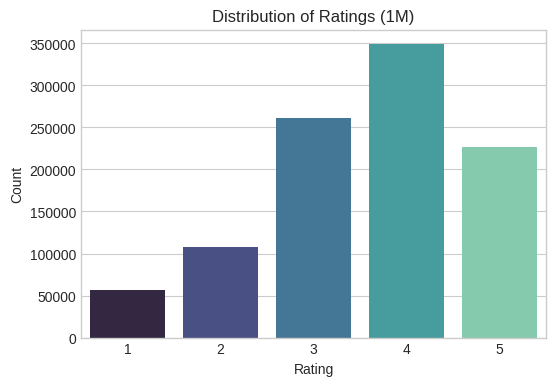

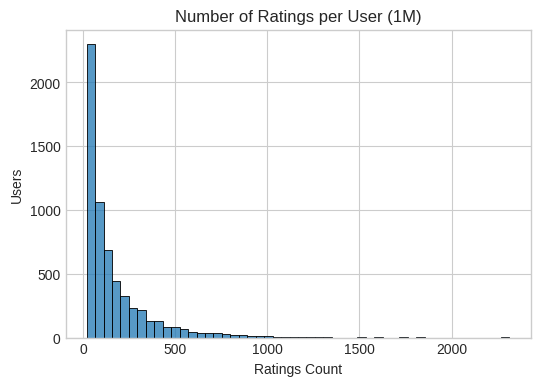

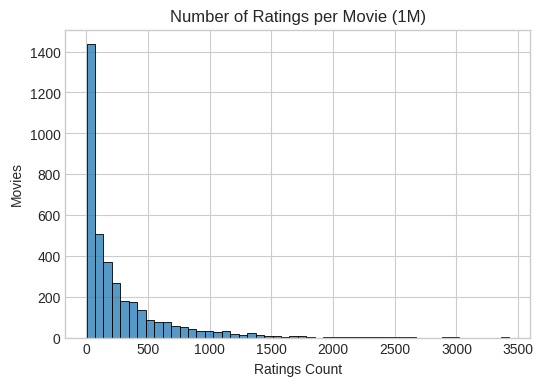


==================== 100k Dataset ====================

--- Dataset Overview ---
Merged DataFrame Shape: (100000, 10)
Ratings DataFrame Shape: (100000, 4)
Movies DataFrame Shape: (1682, 3)
Users DataFrame Shape: (943, 5)

--- Merged Data Head ---
   userId  movieId  rating  timestamp  age gender  occupation zip-code  \
0     196      242       3  881250949   49      M      writer    55105   
1     186      302       3  891717742   39      F   executive    00000   
2      22      377       1  878887116   25      M      writer    40206   
3     244       51       2  880606923   28      M  technician    80525   
4     166      346       1  886397596   47      M    educator    55113   

                        title                            genres  
0                Kolya (1996)                            Comedy  
1    L.A. Confidential (1997)  Crime|Film-Noir|Mystery|Thriller  
2         Heavyweights (1994)                 Children's|Comedy  
3  Legends of the Fall (1994)         Drama

/tmp/ipython-input-162957559.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette="mako")


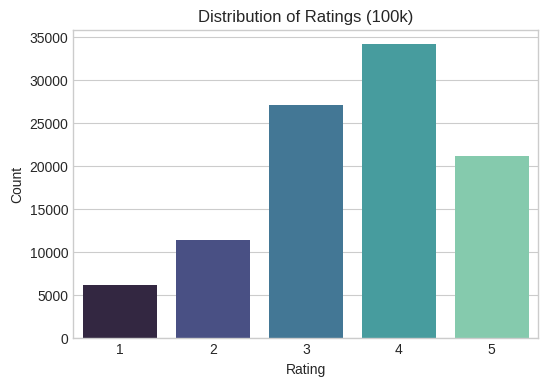

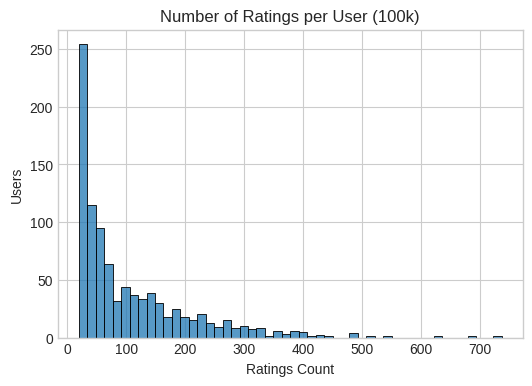

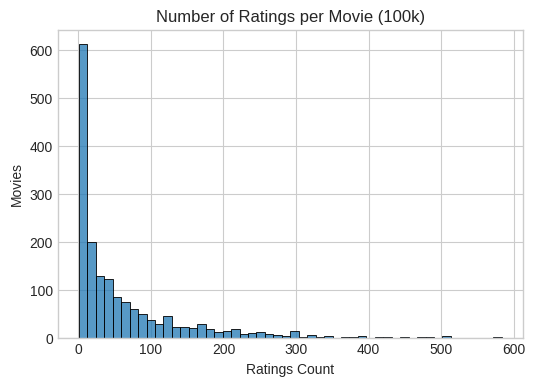

In [ ]:
# --- Dataset Inspection and Visualization for Both Datasets ---

datasets = ['1M', '100k']

for dataset_name in datasets:
    print(f"\n==================== {dataset_name} Dataset ====================")

    merged_df, ratings_df, movies_df, users_df = load_data(dataset_name)
    if merged_df is None:
        continue

    # --- Print Shapes and Head ---
    print("\n--- Dataset Overview ---")
    print("Merged DataFrame Shape:", merged_df.shape)
    print("Ratings DataFrame Shape:", ratings_df.shape)
    print("Movies DataFrame Shape:", movies_df.shape)
    print("Users DataFrame Shape:", users_df.shape)

    print("\n--- Merged Data Head ---")
    print(merged_df.head())

    # --- Rating Distribution ---
    plt.figure(figsize=(6,4))
    sns.countplot(x='rating', data=ratings_df, palette="mako")
    plt.title(f"Distribution of Ratings ({dataset_name})")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()

    # --- Number of Ratings per User ---
    plt.figure(figsize=(6,4))
    ratings_per_user = ratings_df.groupby("userId")["rating"].count()
    sns.histplot(ratings_per_user, bins=50, kde=False)
    plt.title(f"Number of Ratings per User ({dataset_name})")
    plt.xlabel("Ratings Count")
    plt.ylabel("Users")
    plt.show()

    # --- Number of Ratings per Movie ---
    plt.figure(figsize=(6,4))
    ratings_per_movie = ratings_df.groupby("movieId")["rating"].count()
    sns.histplot(ratings_per_movie, bins=50, kde=False)
    plt.title(f"Number of Ratings per Movie ({dataset_name})")
    plt.xlabel("Ratings Count")
    plt.ylabel("Movies")
    plt.show()
